#Import Library yang Digunakan

In [1]:
import numpy as np
import random
import time
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from torch.utils.data import TensorDataset, DataLoader
from google.colab import drive
import warnings
warnings.filterwarnings('ignore')

#Cek GPU

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#Mendefinisikan Model CNN-LSTM

In [3]:
class CNNLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, dropout=0.2):
        super(CNNLSTMModel, self).__init__()
        self.hidden_size = hidden_size
        self.conv1 = nn.Conv1d(in_channels=input_size, out_channels=64, kernel_size=3, padding=1)
        self.pool = nn.MaxPool1d(kernel_size=2)
        self.dropout = nn.Dropout(dropout)
        self.lstm = nn.LSTM(64, hidden_size, batch_first=True, num_layers=1)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.permute(0, 2, 1)
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = x.permute(0, 2, 1)
        lstm_out, _ = self.lstm(x)
        out = self.fc(lstm_out[:, -1, :])
        return out

#Optimasi GWO

In [4]:
def calculate_fitness_cnnlstm(wolf_position, x_train, y_train, x_test, y_test, input_size, scaler):
    model = CNNLSTMModel(
        input_size=input_size,
        hidden_size=int(wolf_position[1]),
        output_size=1
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=float(wolf_position[2]))

    loss_history = []

    # Training
    for epoch in range(int(wolf_position[0])):
        model.train()
        optimizer.zero_grad()
        y_pred = model(x_train)
        loss = criterion(y_pred, y_train.unsqueeze(-1))
        loss.backward()
        optimizer.step()
        loss_history.append(np.sqrt(loss.item()))

    # Evaluation
    model.eval()
    with torch.no_grad():
        y_pred_test = model(x_test).cpu().numpy()
        y_test_np = y_test.cpu().numpy().reshape(-1,1)

        # Mengembalikan ke dalam skala data asli
        y_pred_test_inv = scaler.inverse_transform(y_pred_test)
        y_test_inv = scaler.inverse_transform(y_test_np)

        test_loss = np.sqrt(mean_squared_error(y_test_inv, y_pred_test_inv))

    return test_loss, loss_history, y_pred_test_inv


# Inisialisasi jumlah populasi serigala
def initialize_population(n_wolves, dim, bounds):
    population = []
    for _ in range(n_wolves):
        wolf_position = [random.uniform(bounds[d][0], bounds[d][1]) for d in range(dim)]
        population.append(wolf_position)
    return population

# Update posisi serigala
def update_position(current_pos, alpha_pos, beta_pos, delta_pos, a, bounds, dim):
    new_position = []
    for d in range(dim):
        r1, r2 = random.random(), random.random()
        A1, C1 = 2 * a * r1 - a, 2 * r2
        D_alpha = abs(C1 * alpha_pos[d] - current_pos[d])
        X1 = alpha_pos[d] - A1 * D_alpha

        r1, r2 = random.random(), random.random()
        A2, C2 = 2 * a * r1 - a, 2 * r2
        D_beta = abs(C2 * beta_pos[d] - current_pos[d])
        X2 = beta_pos[d] - A2 * D_beta

        r1, r2 = random.random(), random.random()
        A3, C3 = 2 * a * r1 - a, 2 * r2
        D_delta = abs(C3 * delta_pos[d] - current_pos[d])
        X3 = delta_pos[d] - A3 * D_delta

        new_val = (X1 + X2 + X3) / 3
        new_val = np.clip(new_val, bounds[d][0], bounds[d][1])
        new_position.append(new_val)

    return new_position

#Model CNN-LSTM-GWO

In [5]:
def grey_wolf_optimizer_cnnlstm(x_train, y_train, x_test, y_test, n_wolves_options, max_iter_options, input_size):
    dim = 3
    bounds = [(50, 100),          # epoch
              (16, 128),          # hidden size
              (0.001, 0.5)]      # learning rate
    best_overall_fitness = float('inf')
    best_overall_solution = None
    best_parameters = None
    best_convergence_curve = None

    # DataFrame untuk semua kombinasi hyperparameter
    df_hyperparam_results = pd.DataFrame(columns=[
        "n_wolves", "max_iter", "epochs", "hidden_size", "learning_rate", "RMSE", "MAPE (%)"
    ])

    for n_wolves in n_wolves_options:
        for max_iter in max_iter_options:
            print(f"\nTesting combination: n_wolves={n_wolves}, max_iter={max_iter}")
            start_time = time.time()

            population = initialize_population(n_wolves, dim, bounds)
            alpha_pos, beta_pos, delta_pos = None, None, None
            alpha_score, beta_score, delta_score = float('inf'), float('inf'), float('inf')
            convergence_curve = []
            best_loss_history = []

            for iteration in range(max_iter):
                a = 2 - iteration * (2 / max_iter)
                for pos in population:
                    fitness, loss_history, y_pred_test = calculate_fitness_cnnlstm(
                        pos, x_train, y_train, x_test, y_test, input_size, scaler
                    )

                    if fitness < alpha_score:
                        delta_pos, delta_score = beta_pos, beta_score
                        beta_pos, beta_score = alpha_pos, alpha_score
                        alpha_pos, alpha_score = pos.copy(), fitness
                        best_loss_history = loss_history
                        best_y_pred = y_pred_test
                    elif fitness < beta_score:
                        delta_pos, delta_score = beta_pos, beta_score
                        beta_pos, beta_score = pos.copy(), fitness
                    elif fitness < delta_score:
                        delta_pos, delta_score = pos.copy(), fitness

                convergence_curve.append(alpha_score)
                population = [update_position(pos, alpha_pos, beta_pos, delta_pos, a, bounds, dim) for pos in population]
                if (iteration+1) % 5 == 0:
                    print(f"Iteration {iteration+1}/{max_iter}, Best RMSE: {alpha_score:.3f}")

            runtime = time.time() - start_time

            # Hitung MAPE untuk kombinasi ini
            actual_test = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1,1)).flatten()
            predicted_test = best_y_pred.flatten()
            mape_val = np.mean(np.abs((actual_test - predicted_test)/actual_test)) * 100

            # Menyimpan kombinasi hyperparameter dan RMSE ke DataFrame
            df_hyperparam_results = pd.concat([
                df_hyperparam_results,
                pd.DataFrame([[
                    n_wolves,
                    max_iter,
                    int(alpha_pos[0]),   # epochs
                    int(alpha_pos[1]),   # hidden size
                    alpha_pos[2],        # learning rate
                    alpha_score,          # RMSE
                    mape_val             # MAPE
                ]], columns=df_hyperparam_results.columns)
            ], ignore_index=True)

            if alpha_score < best_overall_fitness:
                best_overall_fitness = alpha_score
                best_overall_solution = alpha_pos.copy()
                best_parameters = {"n_wolves": n_wolves, "max_iter": max_iter}
                final_loss_history = best_loss_history
                best_convergence_curve = convergence_curve
                best_y_pred_overall = best_y_pred

    print("\nSolusi optimal yang diperoleh meliputi:")
    print(f"Hyperparameter GWO Terbaik: n_wolves={best_parameters['n_wolves']}, max_iter={best_parameters['max_iter']}")
    print(f"RMSE Terbaik: {best_overall_fitness:.3f}")
    print("Hyperparameter CNN-LSTM Terbaik:")
    print(f"Epochs: {best_overall_solution[0]:.0f}")
    print(f"Hidden Size: {best_overall_solution[1]:.0f}")
    print(f"Learning Rate: {best_overall_solution[2]:.4f}")

    # Simpan tabel kombinasi hyperparameter ke Excel
    hyperparam_output_path = "/content/drive/MyDrive/Skripsi_TabelHasil/Kombinasi_Hyperparameter.xlsx"
    df_hyperparam_results.to_excel(hyperparam_output_path, index=False)
    print(f"Tabel kombinasi hyperparameter disimpan di: {hyperparam_output_path}")

    # Hitung MAPE total & RMSE final untuk prediksi terbaik
    final_y_test = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1,1))
    final_y_pred = best_y_pred_overall
    rmse_total = np.sqrt(mean_squared_error(final_y_test, final_y_pred))
    mape_total = np.mean(np.abs((final_y_test.flatten() - final_y_pred.flatten()) / final_y_test.flatten())) * 100

    # Plot Training Loss
    plt.figure(figsize=(9,5))
    plt.plot(final_loss_history, color="blue")
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss (MSE)", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # Plot Kurva Konvergensi
    plt.figure(figsize=(9,5))
    plt.plot(best_convergence_curve, color="blue")
    plt.xlabel("Iterasi", fontsize=14)
    plt.ylabel("Best Fitness (RMSE)", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(20))
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # Plot Learning Curve
    train_losses = final_loss_history
    test_losses = []
    model = CNNLSTMModel(
        input_size=input_size,
        hidden_size=int(best_overall_solution[1]),
        output_size=1
    ).to(device)
    optimizer = optim.Adam(model.parameters(), lr=float(best_overall_solution[2]))
    criterion = nn.MSELoss()

    for epoch in range(int(best_overall_solution[0])):
        model.train()
        optimizer.zero_grad()
        y_pred_train = model(x_train)
        loss_train = criterion(y_pred_train, y_train.unsqueeze(-1))
        loss_train.backward()
        optimizer.step()

        model.eval()
        with torch.no_grad():
            y_pred_val = model(x_test)
            loss_val = criterion(y_pred_val, y_test.unsqueeze(-1))
        test_losses.append(np.sqrt(loss_val.item()))

    plt.figure(figsize=(9,5))
    plt.plot(train_losses, label="Training Loss", color="blue")
    plt.plot(test_losses, label="Validation Loss", color="red")
    plt.xlabel("Epochs", fontsize=14)
    plt.ylabel("Loss (MSE)", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax = plt.gca()
    ax.xaxis.set_major_locator(ticker.MultipleLocator(20))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.2))
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    # Mengembalikan data aktual ke dalam skala asli
    final_y_test = scaler.inverse_transform(y_test.cpu().numpy().reshape(-1,1))
    final_y_pred = best_y_pred

    # Visualisasi data prediksi vs aktual
    plt.figure(figsize=(9,5))
    plt.plot(final_y_test, label="Data Aktual", color="red", linestyle="--")
    plt.plot(final_y_pred, label="Data Prediksi", color="blue", linestyle="-")
    plt.xlabel("Indeks Data", fontsize=14)
    plt.ylabel("Harga Penutupan IHSG", fontsize=14)
    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    ax = plt.gca()
    ax.yaxis.set_major_locator(ticker.MultipleLocator(500))
    plt.legend()
    plt.tight_layout()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()

    return best_overall_solution, best_overall_fitness, best_parameters, final_loss_history, final_y_test, final_y_pred, df_hyperparam_results, rmse_total, mape_total

def prepare_data(data, sequence_length):
    scaler = StandardScaler()
    data = scaler.fit_transform(data.reshape(-1,1)).reshape(-1)

    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    X, y = np.array(X), np.array(y)
    train_size = int(len(X) * 0.8)

    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Menambahkan dimensi fitur (input_size=1)
    X_train_torch = torch.tensor(X_train, dtype=torch.float32).unsqueeze(-1).to(device)
    X_test_torch  = torch.tensor(X_test, dtype=torch.float32).unsqueeze(-1).to(device)
    y_train_torch = torch.tensor(y_train, dtype=torch.float32).to(device)
    y_test_torch  = torch.tensor(y_test, dtype=torch.float32).to(device)

    return X_train_torch, y_train_torch, X_test_torch, y_test_torch, X_train_torch.shape[-1], scaler


#Load Data

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

Testing combination: n_wolves=5, max_iter=15
Iteration 5/15, Best RMSE: 113.100
Iteration 10/15, Best RMSE: 100.289
Iteration 15/15, Best RMSE: 96.535

Testing combination: n_wolves=5, max_iter=30
Iteration 5/30, Best RMSE: 122.107
Iteration 10/30, Best RMSE: 93.407
Iteration 15/30, Best RMSE: 87.918
Iteration 20/30, Best RMSE: 87.918
Iteration 25/30, Best RMSE: 87.918
Iteration 30/30, Best RMSE: 87.918

Testing combination: n_wolves=10, max_iter=15
Iteration 5/15, Best RMSE: 88.730
Iteration 10/15, Best RMSE: 83.520
Iteration 15/15, Best RMSE: 83.520

Testing combination: n_wolves=10, max_iter=30
Iteration 5/30, Best RMSE: 90.995
Iteration 10/30, Best RMSE: 90.735
Iteration 15/30, Best RMSE: 83.017
Iteration 20/30, Best RMSE: 83.017
Iteration 25/30, Best RMSE: 83.017
Iteration 30/30, Best RMSE: 83.017

Solusi optimal yang diperoleh meliputi:
Hyperparameter 

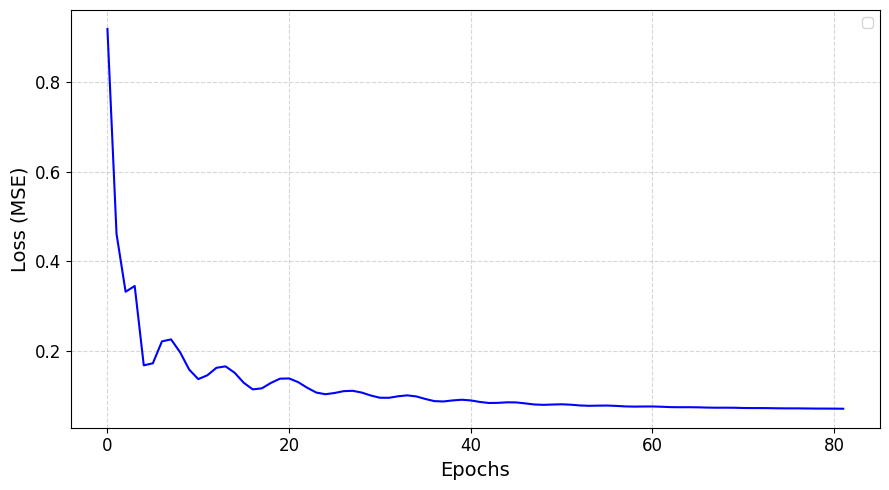

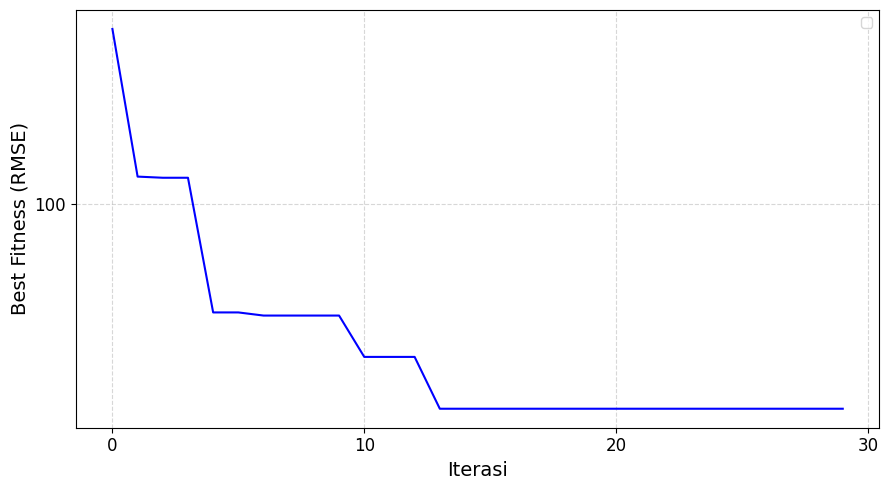

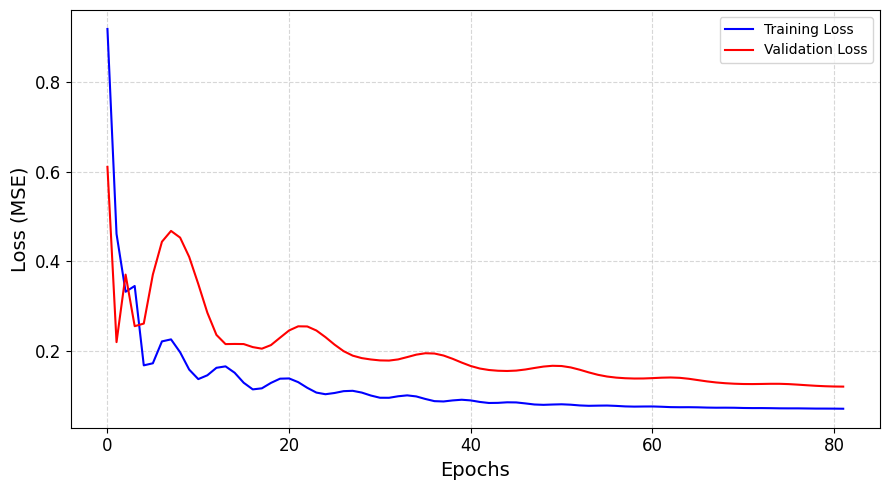

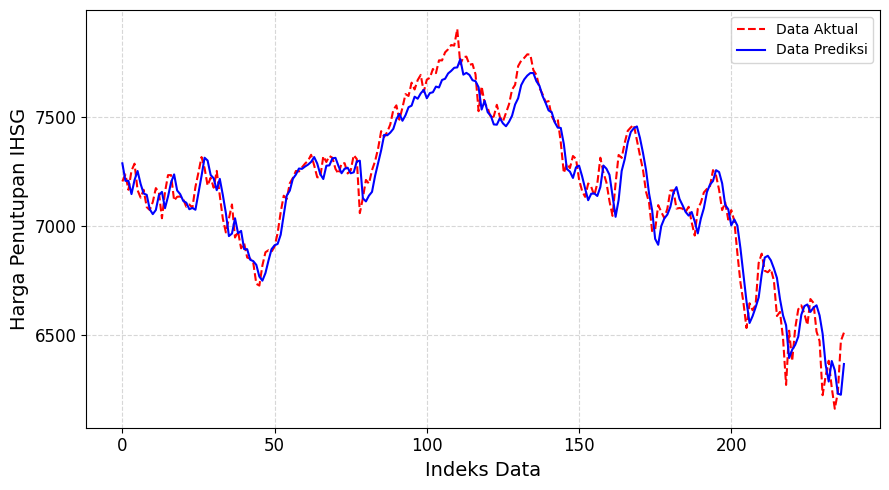

In [6]:
drive.mount('/content/drive')
file_path = "/content/drive/MyDrive/Skripsi_Data IHSG/Data Indeks Harga Saham Gabungan (IHSG).xlsx"
df = pd.read_excel(file_path)
data = df["Close"].values.reshape(-1,1)
sequence_length = 20
X_train, y_train, X_test, y_test, input_size, scaler = prepare_data(data, sequence_length)

max_iter_options = [15, 30]
n_wolves_options = [5, 10]

best_solution, best_fitness, best_params, final_loss_history, final_y_test, final_y_pred, df_hyperparam_results, rmse_total, mape_total = grey_wolf_optimizer_cnnlstm(
    X_train, y_train, X_test, y_test, n_wolves_options, max_iter_options, input_size
)


#Data Aktual dan Data Hasil Prediksi CNN-LSTM-GWO

In [7]:
actual = final_y_test.flatten()
predicted = final_y_pred.flatten()
selisih = actual - predicted

# Menghitung RMSE total
rmse_total = np.sqrt(mean_squared_error(actual, predicted))

# Membuat DataFrame
df_results = pd.DataFrame({
    "Tanggal": df.index[-len(actual):],
    "Data Aktual": actual,
    "Data Prediksi": predicted,
    "Selisih (RMSE)": selisih
})

df_results = pd.concat([
    df_results,
    pd.DataFrame([["", "", "", ""]], columns=df_results.columns),
    pd.DataFrame([["", "RMSE", "", rmse_total]], columns=df_results.columns)
], ignore_index=True)

# Menyimpan ke Excel
output_path = "/content/drive/MyDrive/Skripsi_TabelHasil/Data_Aktual_dan_Prediksi_IHSG.xlsx"
df_results.to_excel(output_path, index=False)

print(f"Hasil tabel disimpan di: {output_path}")

# Menampilkan 5 baris pertama
print(f"Hasil tabel disimpan di: {output_path}")
print("\nPreview 5 baris awal:")
print(df_results.head())

Hasil tabel disimpan di: /content/drive/MyDrive/Skripsi_TabelHasil/Data_Aktual_dan_Prediksi_IHSG.xlsx
Hasil tabel disimpan di: /content/drive/MyDrive/Skripsi_TabelHasil/Data_Aktual_dan_Prediksi_IHSG.xlsx

Preview 5 baris awal:
  Tanggal  Data Aktual Data Prediksi Selisih (RMSE)
0     970  7205.060059   7288.436523     -83.376465
1     971   7236.97998   7208.099121      28.880859
2     972  7166.839844   7208.013672     -41.173828
3     973  7254.399902   7147.075195     107.324707
4     974  7286.879883   7211.476562       75.40332


#Menampilkan 5 Baris Awal Kombinasi Hyperparameter Model CNN-LSTM-GWO

In [8]:
# Menampilkan 5 baris pertama dari tabel kombinasi hyperparameter
print(df_hyperparam_results.head())

  n_wolves max_iter epochs hidden_size  learning_rate       RMSE  MAPE (%)
0        5       15     85          64       0.042410  96.534841  1.063063
1        5       30     83          45       0.014070  87.917892  0.975204
2       10       15     50          67       0.016663  83.520181  0.938120
3       10       30     82          96       0.007377  83.017165  0.931876
